# Q-learning


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.02433908, -0.18708362,  0.01404513,  0.32813949]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.5740530357235736 -2.8477175222014544


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # returning the given data to the model
    return actions, states

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(actions, states, # model input
               action_size, hidden_size): # model init for Qs
        
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits[:-1], 
                                                                     labels=actions_onehot[1:]))
    
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
# from collections import deque

# class Memory():    
#     def __init__(self, max_size = 1000):
#         self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [29]:
# Training parameters
train_episodes = 2000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [30]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# # Init the memory
# memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [31]:
env.reset()

array([-0.03645146, -0.01202375,  0.02545756, -0.03675448])

In [32]:
# # Initialize the simulation
# state = env.reset()
# batch = []

# # Make a bunch of random actions and store the experiences
# for each_step in range(max_steps):
    
#     # Take one random step to get the pole and cart moving
#     action = env.action_space.sample()
#     state, _, done, _ = env.step(action)
#     reward = 1 - float(done)
#     #memory.buffer.append((action, state, reward))
#     batch.append((action, state, reward))
    
#     # End of the episodes which defines the goal of the episode/mission
#     if done is True:
#         # Start new episode
#         #env.reset()
#         break

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [33]:
state, reward, action

(array([-0.10605596, -0.96153423,  0.21081607,  1.97889728]), 0.0, 0.0)

In [34]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        state = env.reset() # env first state
        batch = [] # every data batch

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Get action from model
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            action *= reward
            batch.append([action, state])
            if done is True:
                break
                
        #batch = memory.buffer
        actions = np.array([each[0] for each in batch])
        states = np.array([each[1] for each in batch])
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                 model.states: states})
            
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(len(batch)),
              'Batch loss: {:.9f}'.format(loss))
        print('-------------------------------------------------------------------------------')
        rewards_list.append((ep, len(batch)))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 59 Batch loss: 0.686637878
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 82 Batch loss: 0.680968761
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 59 Batch loss: 0.675425351
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 98 Batch loss: 0.670596540
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4 Total reward: 50 Batch loss: 0.662404299
--------------------

-------------------------------------------------------------------------------
Episode: 40 Total reward: 32 Batch loss: 0.391119003
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 41 Total reward: 38 Batch loss: 0.379147768
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 42 Total reward: 55 Batch loss: 0.329965532
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 43 Total reward: 36 Batch loss: 0.357272446
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 44 Total reward: 48 Batch loss: 0.323824257
---------------

-------------------------------------------------------------------------------
Episode: 81 Total reward: 69 Batch loss: 0.197179124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 82 Total reward: 26 Batch loss: 0.128759563
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 83 Total reward: 39 Batch loss: 0.196023270
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 84 Total reward: 50 Batch loss: 0.115239941
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 85 Total reward: 33 Batch loss: 0.210129768
---------------

-------------------------------------------------------------------------------
Episode: 124 Total reward: 51 Batch loss: 0.203220725
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 125 Total reward: 36 Batch loss: 0.175454542
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 126 Total reward: 70 Batch loss: 0.102424681
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 127 Total reward: 39 Batch loss: 0.052919600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 128 Total reward: 26 Batch loss: 0.251402438
----------

-------------------------------------------------------------------------------
Episode: 165 Total reward: 48 Batch loss: 0.085084833
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 166 Total reward: 36 Batch loss: 0.109445289
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 27 Batch loss: 0.078492597
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 59 Batch loss: 0.093275525
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 44 Batch loss: 0.090937123
----------

-------------------------------------------------------------------------------
Episode: 205 Total reward: 64 Batch loss: 0.164853722
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 206 Total reward: 30 Batch loss: 0.102664798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 207 Total reward: 32 Batch loss: 0.098121807
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 96 Batch loss: 0.050586831
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 43 Batch loss: 0.050496072
----------

-------------------------------------------------------------------------------
Episode: 245 Total reward: 30 Batch loss: 0.066011764
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 54 Batch loss: 0.044254716
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 27 Batch loss: 0.070051841
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 248 Total reward: 24 Batch loss: 0.111900285
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 249 Total reward: 26 Batch loss: 0.080070913
----------

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 289 Total reward: 46 Batch loss: 0.037940677
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 290 Total reward: 59 Batch loss: 0.118069902
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 291 Total reward: 29 Batch loss: 0.212566957
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 292 Total reward: 62 Batch loss: 0.047205027
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 330 Total reward: 84 Batch loss: 0.024542723
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 331 Total reward: 34 Batch loss: 0.049616762
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 332 Total reward: 30 Batch loss: 0.106417730
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 333 Total reward: 40 Batch loss: 0.042741608
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 334 Total reward: 22 Batch loss: 0.073470794
----------

-------------------------------------------------------------------------------
Episode: 372 Total reward: 21 Batch loss: 0.158067465
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 373 Total reward: 27 Batch loss: 0.118129559
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 374 Total reward: 32 Batch loss: 0.163770691
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 375 Total reward: 17 Batch loss: 0.191010728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 376 Total reward: 49 Batch loss: 0.060133949
----------

-------------------------------------------------------------------------------
Episode: 414 Total reward: 53 Batch loss: 0.077398568
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 415 Total reward: 63 Batch loss: 0.103250906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 70 Batch loss: 0.135350928
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 19 Batch loss: 0.208330750
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 97 Batch loss: 0.080240376
----------

-------------------------------------------------------------------------------
Episode: 456 Total reward: 14 Batch loss: 0.112000473
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 457 Total reward: 16 Batch loss: 0.098947644
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 458 Total reward: 34 Batch loss: 0.055370033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 459 Total reward: 24 Batch loss: 0.061468415
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 460 Total reward: 33 Batch loss: 0.112526819
----------

-------------------------------------------------------------------------------
Episode: 497 Total reward: 45 Batch loss: 0.022601606
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 498 Total reward: 32 Batch loss: 0.016070548
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 499 Total reward: 27 Batch loss: 0.050786059
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 500 Total reward: 23 Batch loss: 0.053954408
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 501 Total reward: 23 Batch loss: 0.087447107
----------

-------------------------------------------------------------------------------
Episode: 537 Total reward: 19 Batch loss: 0.062144682
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 538 Total reward: 45 Batch loss: 0.030404866
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 539 Total reward: 56 Batch loss: 0.088513702
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 17 Batch loss: 0.079711497
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541 Total reward: 17 Batch loss: 0.066258274
----------

-------------------------------------------------------------------------------
Episode: 580 Total reward: 40 Batch loss: 0.023532458
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 581 Total reward: 68 Batch loss: 0.038748201
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 582 Total reward: 24 Batch loss: 0.035365675
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 583 Total reward: 34 Batch loss: 0.028257297
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 584 Total reward: 21 Batch loss: 0.037595227
----------

-------------------------------------------------------------------------------
Episode: 623 Total reward: 15 Batch loss: 0.058551032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 45 Batch loss: 0.018410679
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 59 Batch loss: 0.191110700
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 626 Total reward: 37 Batch loss: 0.027322875
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 627 Total reward: 88 Batch loss: 0.034355305
----------

-------------------------------------------------------------------------------
Episode: 666 Total reward: 20 Batch loss: 0.030654719
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 667 Total reward: 18 Batch loss: 0.041321307
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 668 Total reward: 59 Batch loss: 0.128784850
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 22 Batch loss: 0.026233653
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 23 Batch loss: 0.032901499
----------

-------------------------------------------------------------------------------
Episode: 707 Total reward: 35 Batch loss: 0.014378390
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 708 Total reward: 91 Batch loss: 0.013908120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 709 Total reward: 68 Batch loss: 0.008238129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 710 Total reward: 26 Batch loss: 0.023725813
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 711 Total reward: 20 Batch loss: 0.037394132
----------

-------------------------------------------------------------------------------
Episode: 747 Total reward: 24 Batch loss: 0.028394228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 748 Total reward: 23 Batch loss: 0.029101627
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 749 Total reward: 101 Batch loss: 0.038431626
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 750 Total reward: 36 Batch loss: 0.021685148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 751 Total reward: 22 Batch loss: 0.026170453
---------

-------------------------------------------------------------------------------
Episode: 787 Total reward: 112 Batch loss: 0.053001013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 788 Total reward: 48 Batch loss: 0.011536317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 789 Total reward: 30 Batch loss: 0.015282663
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 790 Total reward: 116 Batch loss: 0.078729898
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 791 Total reward: 25 Batch loss: 0.025089450
--------

-------------------------------------------------------------------------------
Episode: 827 Total reward: 105 Batch loss: 0.040244870
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 828 Total reward: 61 Batch loss: 0.006886070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 829 Total reward: 33 Batch loss: 0.016701078
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 830 Total reward: 23 Batch loss: 0.016303450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 831 Total reward: 37 Batch loss: 0.015747426
---------

-------------------------------------------------------------------------------
Episode: 866 Total reward: 112 Batch loss: 0.045517512
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 867 Total reward: 53 Batch loss: 0.009493821
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 868 Total reward: 41 Batch loss: 0.018418802
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 869 Total reward: 25 Batch loss: 0.030895904
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 870 Total reward: 71 Batch loss: 0.021464616
---------

-------------------------------------------------------------------------------
Episode: 909 Total reward: 27 Batch loss: 0.024962921
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 910 Total reward: 62 Batch loss: 0.044681847
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 911 Total reward: 20 Batch loss: 0.020511189
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 912 Total reward: 65 Batch loss: 0.017117441
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 913 Total reward: 87 Batch loss: 0.035139609
----------

-------------------------------------------------------------------------------
Episode: 951 Total reward: 22 Batch loss: 0.016244911
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 952 Total reward: 169 Batch loss: 0.044756789
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 953 Total reward: 99 Batch loss: 0.035077497
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 954 Total reward: 30 Batch loss: 0.043872755
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 955 Total reward: 45 Batch loss: 0.006703630
---------

-------------------------------------------------------------------------------
Episode: 994 Total reward: 67 Batch loss: 0.019439887
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 995 Total reward: 22 Batch loss: 0.027074927
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 996 Total reward: 24 Batch loss: 0.032334246
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 997 Total reward: 40 Batch loss: 0.015951589
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 998 Total reward: 18 Batch loss: 0.032866932
----------

-------------------------------------------------------------------------------
Episode: 1037 Total reward: 28 Batch loss: 0.010926492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1038 Total reward: 74 Batch loss: 0.005652240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1039 Total reward: 26 Batch loss: 0.011711516
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1040 Total reward: 19 Batch loss: 0.021451917
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1041 Total reward: 21 Batch loss: 0.012566817
-----

-------------------------------------------------------------------------------
Episode: 1079 Total reward: 24 Batch loss: 0.018595140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1080 Total reward: 51 Batch loss: 0.009667221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1081 Total reward: 28 Batch loss: 0.026448684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1082 Total reward: 32 Batch loss: 0.009700955
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1083 Total reward: 18 Batch loss: 0.027754599
-----

-------------------------------------------------------------------------------
Episode: 1123 Total reward: 128 Batch loss: 0.062249191
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1124 Total reward: 18 Batch loss: 0.017106399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1125 Total reward: 28 Batch loss: 0.013510549
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1126 Total reward: 20 Batch loss: 0.029165519
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1127 Total reward: 16 Batch loss: 0.018091846
----

-------------------------------------------------------------------------------
Episode: 1164 Total reward: 55 Batch loss: 0.003896013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1165 Total reward: 21 Batch loss: 0.021946652
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1166 Total reward: 142 Batch loss: 0.042135950
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1167 Total reward: 35 Batch loss: 0.017851682
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1168 Total reward: 53 Batch loss: 0.005627031
----

-------------------------------------------------------------------------------
Episode: 1207 Total reward: 38 Batch loss: 0.005230515
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1208 Total reward: 37 Batch loss: 0.007672314
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1209 Total reward: 45 Batch loss: 0.007831471
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1210 Total reward: 33 Batch loss: 0.022020647
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1211 Total reward: 28 Batch loss: 0.022320345
-----

-------------------------------------------------------------------------------
Episode: 1250 Total reward: 28 Batch loss: 0.010799333
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1251 Total reward: 18 Batch loss: 0.015788447
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1252 Total reward: 24 Batch loss: 0.011509347
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1253 Total reward: 22 Batch loss: 0.028670207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1254 Total reward: 116 Batch loss: 0.039064143
----

-------------------------------------------------------------------------------
Episode: 1295 Total reward: 18 Batch loss: 0.031769633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1296 Total reward: 22 Batch loss: 0.010468180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1297 Total reward: 29 Batch loss: 0.021198679
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1298 Total reward: 101 Batch loss: 0.047119040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1299 Total reward: 22 Batch loss: 0.021639774
----

-------------------------------------------------------------------------------
Episode: 1335 Total reward: 28 Batch loss: 0.006026574
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1336 Total reward: 36 Batch loss: 0.009552504
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1337 Total reward: 26 Batch loss: 0.020401869
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1338 Total reward: 44 Batch loss: 0.005321001
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1339 Total reward: 96 Batch loss: 0.031280752
-----

-------------------------------------------------------------------------------
Episode: 1375 Total reward: 49 Batch loss: 0.010298445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1376 Total reward: 18 Batch loss: 0.013758473
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1377 Total reward: 24 Batch loss: 0.013611738
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1378 Total reward: 101 Batch loss: 0.015268086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1379 Total reward: 30 Batch loss: 0.019815268
----

-------------------------------------------------------------------------------
Episode: 1416 Total reward: 64 Batch loss: 0.010886651
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1417 Total reward: 112 Batch loss: 0.032855466
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1418 Total reward: 37 Batch loss: 0.006230468
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1419 Total reward: 35 Batch loss: 0.003671417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1420 Total reward: 23 Batch loss: 0.014960182
----

-------------------------------------------------------------------------------
Episode: 1460 Total reward: 81 Batch loss: 0.011008264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1461 Total reward: 50 Batch loss: 0.025350709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1462 Total reward: 29 Batch loss: 0.010566964
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1463 Total reward: 27 Batch loss: 0.003330416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1464 Total reward: 21 Batch loss: 0.014914627
-----

-------------------------------------------------------------------------------
Episode: 1500 Total reward: 24 Batch loss: 0.018590163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1501 Total reward: 44 Batch loss: 0.002846065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1502 Total reward: 21 Batch loss: 0.015886437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1503 Total reward: 30 Batch loss: 0.010339602
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1504 Total reward: 46 Batch loss: 0.004613874
-----

-------------------------------------------------------------------------------
Episode: 1540 Total reward: 57 Batch loss: 0.003051481
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1541 Total reward: 73 Batch loss: 0.017415570
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1542 Total reward: 39 Batch loss: 0.006417722
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1543 Total reward: 21 Batch loss: 0.008013639
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1544 Total reward: 29 Batch loss: 0.003246545
-----

-------------------------------------------------------------------------------
Episode: 1580 Total reward: 31 Batch loss: 0.008637008
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1581 Total reward: 26 Batch loss: 0.005663278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1582 Total reward: 35 Batch loss: 0.012097455
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1583 Total reward: 17 Batch loss: 0.011281005
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1584 Total reward: 36 Batch loss: 0.003523031
-----

-------------------------------------------------------------------------------
Episode: 1623 Total reward: 26 Batch loss: 0.013162302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1624 Total reward: 94 Batch loss: 0.013334321
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1625 Total reward: 20 Batch loss: 0.015687056
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1626 Total reward: 18 Batch loss: 0.021656459
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1627 Total reward: 130 Batch loss: 0.011082742
----

-------------------------------------------------------------------------------
Episode: 1663 Total reward: 119 Batch loss: 0.031006051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1664 Total reward: 35 Batch loss: 0.004698823
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1665 Total reward: 22 Batch loss: 0.012196508
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1666 Total reward: 24 Batch loss: 0.019999158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1667 Total reward: 30 Batch loss: 0.002790019
----

Episode: 1705 Total reward: 34 Batch loss: 0.016866971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1706 Total reward: 23 Batch loss: 0.003102984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1707 Total reward: 80 Batch loss: 0.001236078
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1708 Total reward: 83 Batch loss: 0.033146694
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1709 Total reward: 41 Batch loss: 0.004889483
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 1745 Total reward: 24 Batch loss: 0.005760965
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1746 Total reward: 104 Batch loss: 0.185011059
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1747 Total reward: 25 Batch loss: 0.002713684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1748 Total reward: 32 Batch loss: 0.020647187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1749 Total reward: 26 Batch loss: 0.008782878
----

-------------------------------------------------------------------------------
Episode: 1785 Total reward: 30 Batch loss: 0.002741918
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1786 Total reward: 117 Batch loss: 0.013471021
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1787 Total reward: 35 Batch loss: 0.013194316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1788 Total reward: 36 Batch loss: 0.001246338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1789 Total reward: 22 Batch loss: 0.007188004
----

-------------------------------------------------------------------------------
Episode: 1827 Total reward: 27 Batch loss: 0.009720158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1828 Total reward: 26 Batch loss: 0.004011351
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1829 Total reward: 118 Batch loss: 0.030090220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1830 Total reward: 48 Batch loss: 0.004239642
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1831 Total reward: 30 Batch loss: 0.001359659
----

-------------------------------------------------------------------------------
Episode: 1869 Total reward: 160 Batch loss: 0.035262629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1870 Total reward: 28 Batch loss: 0.034113482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1871 Total reward: 21 Batch loss: 0.019309476
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1872 Total reward: 25 Batch loss: 0.009024523
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1873 Total reward: 33 Batch loss: 0.003134751
----

-------------------------------------------------------------------------------
Episode: 1908 Total reward: 123 Batch loss: 0.032301962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1909 Total reward: 29 Batch loss: 0.001609645
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1910 Total reward: 29 Batch loss: 0.005858289
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1911 Total reward: 22 Batch loss: 0.016082482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1912 Total reward: 30 Batch loss: 0.006175940
----

-------------------------------------------------------------------------------
Episode: 1948 Total reward: 51 Batch loss: 0.004236434
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1949 Total reward: 30 Batch loss: 0.016122315
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1950 Total reward: 21 Batch loss: 0.021926763
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1951 Total reward: 21 Batch loss: 0.005131946
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1952 Total reward: 34 Batch loss: 0.001640827
-----

-------------------------------------------------------------------------------
Episode: 1990 Total reward: 46 Batch loss: 0.002899370
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1991 Total reward: 30 Batch loss: 0.002027911
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1992 Total reward: 36 Batch loss: 0.002062809
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1993 Total reward: 23 Batch loss: 0.010833134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1994 Total reward: 46 Batch loss: 0.000982533
-----

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

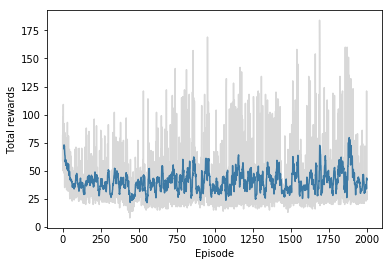

In [40]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

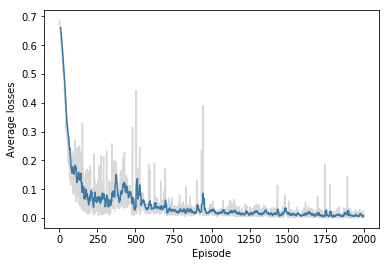

In [41]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [42]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for each_episode in range(1):

        # Start a new episode/epoch
        state = env.reset()
        
        # Rendering the env graphics
        env.render()

        # Steps/batches
        for each_step in range(111111111111111111):
                        
            # Calculating next action using OLD memory
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            #reward = 1 - float(done)
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-pg.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.